## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pindah ke folder yang terdapat dataset
%cd /content/drive/MyDrive/Capstone

/content/drive/MyDrive/Capstone


## Import Libraries

In [ ]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import shutil
import json
import tempfile
import requests
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.image as mpimg
from tensorflow.keras.applications import efficientnet

## Data Load

In [ ]:
# Path untuk set pelatihan, validasi, dan pengujian
train_path = "dataset/train"
valid_path = "dataset/val"
test_path = "dataset/test"

# Path data asli
original_data_path = "dataset/citra_bisindo"

In [ ]:
# Mendapatkan daftar folder kelas
class_folders = os.listdir(original_data_path)

In [ ]:
# Memindahkan data ke folder train, test, dan val
for class_folder in class_folders:
    class_folder_path = os.path.join(original_data_path, class_folder)
    files = os.listdir(class_folder_path)
    train_files, validation_test_files = train_test_split(files, test_size=0.3, random_state=42)

    for file in train_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    validation_files, test_files = train_test_split(validation_test_files, test_size=0.5, random_state=42)

    for file in test_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file in validation_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(valid_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [ ]:
# Function to count files in a folder
def count_files(folder_path):
    count = sum([len(files) for root, dirs, files in os.walk(folder_path)])
    return count

# Count files in each folder
citra_files = count_files(original_data_path)
train_files = count_files(train_path)
test_files = count_files(test_path)
valid_files = count_files(valid_path)

# Print the counts
print("Number of files in 'citra':", citra_files)
print("Number of files in 'train':", train_files)
print("Number of files in 'test':", test_files)
print("Number of files in 'valid':", valid_files)

Number of files in 'citra': 1638
Number of files in 'train': 1144
Number of files in 'test': 260
Number of files in 'valid': 234


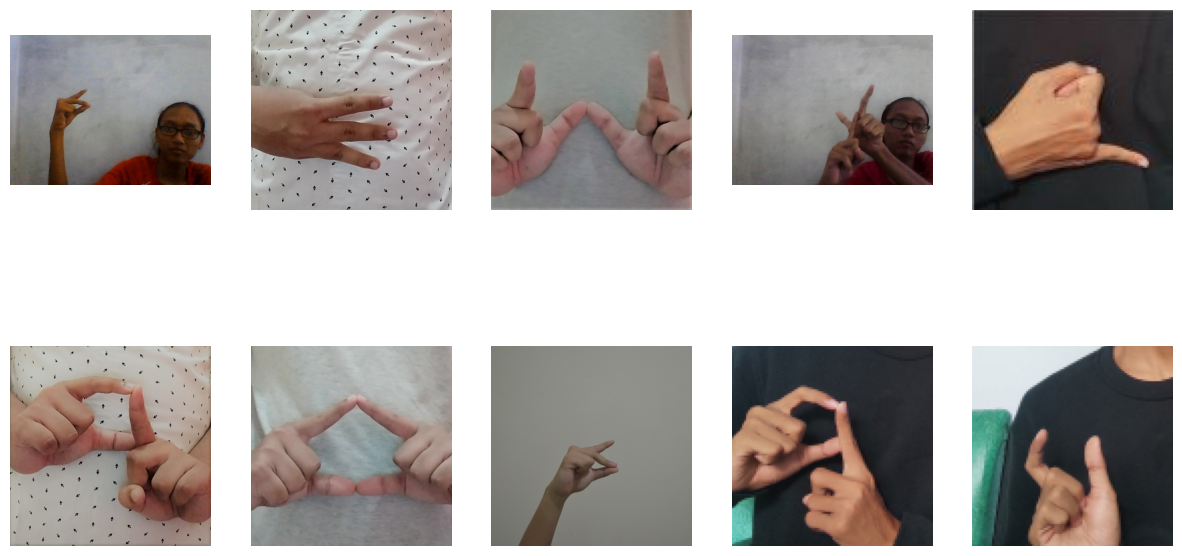

In [ ]:
# Function to get a list of image files from a folder
def get_image_files(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get list of all image files in 'train' folder
train_image_files = get_image_files(train_path)

# Randomly select 10 image files
random_10_images = random.sample(train_image_files, 10)

# Plot the images
fig = plt.figure(figsize=(15, 8))
for i, image_path in enumerate(random_10_images, 1):
    ax = fig.add_subplot(2, 5, i)
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

## Data Pre-Processing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Step 3. Generate Image Generator for Train
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    #shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1144 images belonging to 26 classes.
Found 260 images belonging to 26 classes.


In [ ]:
# Menghitung jumlah data untuk setiap bagian
total_samples = train_generator.samples
num_train_samples = int(total_samples * train_ratio)
num_validation_samples = int(total_samples * validation_ratio)
num_test_samples = int(total_samples * test_ratio)

In [ ]:
# Extract a batch of data from the generator
images, labels = next(train_generator)

# Print the shape of the batch of images and labels
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 26)


In [ ]:
# Extract a batch of data from the generator
images, labels = next(test_generator)

# Print the shape of the batch of images and labels
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 26)


## Model Building

In [ ]:
# Define Additional Variabel for Model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
# Load pre-trained EfficientNetB1 model
en_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

# Add GlobalAveragePooling2D layer
x = en_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add Dense output layer for your classification task
predictions = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
ENB1_model = tf.keras.models.Model(inputs=en_model.input, outputs=predictions)

# Freeze all layers except for BatchNormalization layers for fine-tuning
for layer in en_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Print model summary
ENB1_model.summary()

27018416/27018416 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
ENB1_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy']
)

ENB1_history = ENB1_model.fit(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      epochs=20,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_TEST,
      verbose=1
)

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 3.3337 - accuracy: 0.0511

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x794a568c1440>